# FiftyOne: Flower Dataset - Classification

This example was completely done by me, using the [Flowers dataset](https://www.kaggle.com/datasets/imsparsh/flowers-dataset) from Kaggle, placed in the local folder `data/flowers` (not committed).

Additionally, instead of using the images of the dataset directly, I used image vectors created with SimCLR in my other repository [simclr_pytorch_flowers](https://github.com/mxagar/simclr_pytorch_flowers): `datasets/vectors_dataset.csv`. The CSV compiles for each image the following information:

- `filename`
- `filepath`
- `label`: ground truth flower label: daisy, dandelion, rose, sunflower, tulip
- `linear_pred`: prediction with downstream ANN
- `embedding`: vector generated with SimCLR
- `cluster`: a cluster value, which could be compared to an unsupervised class pr

Table of contents:

1. Load Dataset File
2. Create FiftyOne Dataset and Visualize It
3. Train Model and Evaluate Predictions
4. Evaluate the Predictions
    - Views / Filtersdiction.


In [41]:
import os
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import ast

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob

from sklearn.manifold import TSNE

## 1. Load Dataset File

In [2]:
df = pd.read_csv('../datasets/vectors_dataset.csv')
df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [3]:
df.columns

Index(['filename', 'filepath', 'label', 'linear_pred', 'embedding', 'cluster'], dtype='object')

In [4]:
df.head()

,filename,filepath,label,linear_pred,embedding,cluster
0,10140303196_b88d3d6cec.jpg,../datasets/flowers/train\daisy\10140303196_b8...,daisy,daisy,"[-0.5338386297225952, -0.7343480587005615, 0.3...",2
1,10172379554_b296050f82_n.jpg,../datasets/flowers/train\daisy\10172379554_b2...,daisy,daisy,"[0.058685123920440674, -1.1110296249389648, 0....",1
2,10172567486_2748826a8b.jpg,../datasets/flowers/train\daisy\10172567486_27...,daisy,daisy,"[-0.2931477725505829, -1.0281589031219482, 0.0...",2
3,10172636503_21bededa75_n.jpg,../datasets/flowers/train\daisy\10172636503_21...,daisy,daisy,"[-0.8797124624252319, -0.700323760509491, -0.0...",1
4,10391248763_1d16681106_n.jpg,../datasets/flowers/train\daisy\10391248763_1d...,daisy,daisy,"[0.512474000453949, -0.4610719680786133, 0.934...",1


In [5]:
def get_absolute_path(relative_path):
    """
    Given a relative file path,
    resolve its absolute path.
    """
    base_path = Path.cwd()  # gets the current working directory
    absolute_path = (base_path / relative_path).resolve()
    return absolute_path

def visualize_image(df, index, filepath_col="filepath"):
    """
    Visualizes an image given the index of the DataFrame row.
    
    Parameters:
    - df: pandas DataFrame containing the file paths of images under the column filepath_col
    - index: Index (int) of the DataFrame row containing the file path
    - filepath_col (str): column nam ein df which contains the file paths; default: "filepath"
    """
    if index < 0 or index >= len(df):
        raise ValueError("Index out of bounds")

    # Assuming the 'filepath' column contains relative paths like '../datasets/flowers/train/daisy/image.jpg'
    relative_image_path = df.iloc[index][filepath_col]
    
    # Convert to absolute path
    absolute_image_path = get_absolute_path(relative_image_path)

    # Load and display the image
    img = mpimg.imread(absolute_image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()

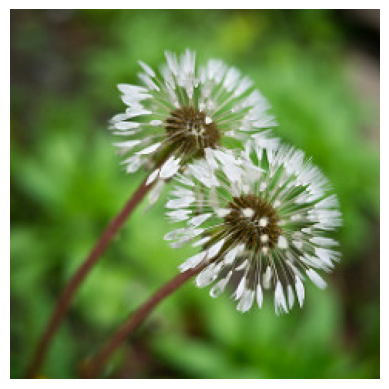

In [6]:
visualize_image(df,1000)

In [7]:
# Convert 'filepath' to absolute paths
df['filepath'] = df['filepath'].apply(get_absolute_path)

## 2. Create FiftyOne Dataset and Visualize It

In [72]:
DATASET_NAME = "flowers_dataset"

In [73]:
# List all available datasets in FiftyOne
dataset_list = fo.list_datasets()
print(dataset_list)

['Iris_Error_Analysis', 'flowers_dataset', 'malaria-cell-images', 'mnist']


In [74]:
if DATASET_NAME in set(dataset_list):
    fo.delete_dataset(DATASET_NAME)

In [75]:
# Initialize FiftyOne dataset
dataset = fo.Dataset(DATASET_NAME)
print(fo.list_datasets())

['Iris_Error_Analysis', 'flowers_dataset', 'malaria-cell-images', 'mnist']


In [76]:
# Loop over DataFrame's rows and create FiftyOne samples
for index, row in df.iterrows():
    # Create FiftyOne sample
    sample = fo.Sample(
        filepath=row['filepath'],
        ground_truth=fo.Classification(label=row['label']),
        linear_pred=fo.Classification(label=row['linear_pred']),
        # Add embedding as a FiftyOne vector field; must convert to a list
        embedding=np.array(row['embedding']).tolist(),
        # Convert cluster id to string before creating Classification
        cluster=fo.Classification(label=str(row['cluster']))
    )

    # Add sample to dataset
    dataset.add_sample(sample)

In [24]:
# Launch the FiftyOne app
# Right click on cell -> Create New View for Cell Output
session = fo.launch_app(dataset)

In [77]:
# Optional: Create 2D embeddings for visualization with UMAP or t-SNE
# Extract embeddings into a numpy array
embeddings = np.stack(df['embedding'].values)

# Compute 2D embeddings
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

In [78]:
# Add 2D embeddings to the samples
for sample, embedding_2d in zip(dataset, reduced_embeddings):
    sample['embedding_tsne_2d'] = embedding_2d.tolist()
    sample.save()

# Save the dataset after all samples are added
dataset.save()

In [79]:
# Compute visual uniqueness
# https://docs.voxel51.com/user_guide/brain.html#image-uniqueness
# A model is downloaded for us and a scalar [0, 1]
# related to the uniqueness of each image is computed
# following different computations: embeddings, neighbors, etc.
# Unique samples are vital in creating training batches
# that help your model learn as efficiently and effectively as possible.
fob.compute_uniqueness(dataset)

Computing embeddings...
 100% |███████████████| 2746/2746 [51.7s elapsed, 0s remaining, 59.0 samples/s]      
Computing uniqueness...
Uniqueness computation complete


In [80]:
# Delete the field from the dataset
try:
    dataset.delete_sample_field("embedding_2d")
except AttributeError as err:
    pass

In [81]:
# Compute 2D representation
# We can select one of the default methods
# point to a model or a field in our dataset where vectors are stored
# https://docs.voxel51.com/api/fiftyone.brain.html#fiftyone.brain.compute_visualization
results = fob.compute_visualization(
    dataset,
    points=reduced_embeddings,
    brain_key="flowers_tsne_2d",
    verbose=True,
    seed=51,
)
# Now, we can reload the UI frame
# check the "Embeddings" tab in the main frame
# There, we select the brain_key "flowers_tsne_2d"

Ignoring unsupported parameters {'verbose', 'seed'} for <class 'fiftyone.brain.visualization.ManualVisualizationConfig'>


In [48]:
plot = results.visualize(labels="ground_truth.label")
plot.show(height=720)

FigureWidget({
    'data': [{'customdata': array(['6548b828cfb24599154248ac', '6548b828cfb24599154248b0',
                                   '6548b828cfb24599154248b4', ..., '6548b829cfb2459915425074',
                                   '6548b829cfb2459915425078', '6548b829cfb245991542507c'], dtype=object),
              'hovertemplate': ('<b>label: %{text}</b><br>x, y ' ... ': %{customdata}<extra></extra>'),
              'line': {'color': '#3366CC'},
              'mode': 'markers',
              'name': 'daisy',
              'showlegend': True,
              'text': array(['daisy', 'daisy', 'daisy', ..., 'daisy', 'daisy', 'daisy'], dtype='<U5'),
              'type': 'scattergl',
              'uid': '5e6fb609-2696-4b9b-a14d-4a16cc28a0bb',
              'x': array([25.155155, 44.89105 ,  8.613078, ..., 30.078953, 30.749   , 10.42914 ],
                         dtype=float32),
              'y': array([-21.573757,   9.9862  , -42.470093, ..., -37.049175, -34.972706,
                

In [49]:
# Attach plot to session:
# necessary to interact with Plotly -> Web UI
session.plots.attach(plot)

## 3. Train Model and Evaluate Predictions

In [82]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [83]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    clf = XGBClassifier(**param)

    return cross_val_score(clf, X_train, y_train, n_jobs=-1, scoring='f1_macro', cv=3).mean()

In [84]:
X = np.stack(df['embedding'].values)
y_org = df['label'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_org)

In [85]:
# Perform the split and get the indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X,
    y,
    range(X.shape[0]),
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-11-06 11:00:01,751] A new study created in memory with name: no-name-c3008a7c-f153-41c2-a3db-fcb4478752a7
[I 2023-11-06 11:00:05,770] Trial 0 finished with value: 0.6928029764911333 and parameters: {'n_estimators': 155, 'max_depth': 3, 'learning_rate': 0.07513287787099064, 'subsample': 0.8709669544714669, 'colsample_bytree': 0.5718206019933547, 'min_child_weight': 184}. Best is trial 0 with value: 0.6928029764911333.
[I 2023-11-06 11:00:15,131] Trial 1 finished with value: 0.803522710901408 and parameters: {'n_estimators': 685, 'max_depth': 13, 'learning_rate': 0.13821833983380175, 'subsample': 0.8569675448619065, 'colsample_bytree': 0.783980911789999, 'min_child_weight': 106}. Best is trial 1 with value: 0.803522710901408.
[I 2023-11-06 11:00:19,804] Trial 2 finished with value: 0.5818246648894086 and parameters: {'n_estimators': 186, 'max_depth': 22, 'learning_rate': 0.29046726780713983, 'subsample': 0.9324762151426215, 'colsample_bytree': 0.862204365756897, 'min_child_weight

In [37]:
best_params = study.best_params
print("Best params:", best_params)

Best params: {'n_estimators': 814, 'max_depth': 9, 'learning_rate': 0.011367536169891529, 'subsample': 0.6431494822093409, 'colsample_bytree': 0.5175255445006837, 'min_child_weight': 1}


In [38]:
xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5175255445006837, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011367536169891529,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=814, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [43]:
# Persist model
model_filename = os.path.join("models", "xgboost_flowers.joblib")
joblib.dump(xgb_clf,
            model_filename)

['models\\xgboost_flowers.joblib']

In [86]:
# Load persisted model
xgb_clf = joblib.load(model_filename)

In [87]:
# Get the predicted probabilities for each class
train_probabilities = xgb_clf.predict_proba(X_train)
test_probabilities = xgb_clf.predict_proba(X_test)

In [88]:
def probabilities_to_logits(probabilities):
    # This is an approximation and may not be accurate,
    # especially for probabilities close to 0 or 1
    # If we have access to the logits (like in a NN), we should use them
    # The problem with XGBoost ist that we don't have logits,
    # so we approximate them from the probabilities
    probabilities = np.clip(probabilities, 1e-15, 1 - 1e-15)  # Avoid division by zero or log(0)
    return np.log(probabilities / (1 - probabilities))

In [89]:
# Create dictionaries to map from index to prediction,
# including the probabilities
train_predictions = {
    idx: {
        'label': label_encoder.inverse_transform([label])[0],
        'confidence': confidence,
        #'probabilities': probabilities.tolist(),
        'logits': probabilities_to_logits(probabilities).tolist()
    }
    for idx, label, confidence, probabilities in zip(
        indices_train,
        np.argmax(train_probabilities, axis=1),
        np.max(train_probabilities, axis=1),
        train_probabilities
    )
}

test_predictions = {
    idx: {
        'label': label_encoder.inverse_transform([label])[0],
        'confidence': confidence,
        #'probabilities': probabilities.tolist(),
        'logits': probabilities_to_logits(probabilities).tolist()        
    }
    for idx, label, confidence, probabilities in zip(
        indices_test,
        np.argmax(test_probabilities, axis=1),
        np.max(test_probabilities, axis=1),
        test_probabilities
    )
}

In [90]:
def add_predictions(df,
                    dataset,
                    train_predictions,
                    test_predictions):
    # Add predictions, probabilities, and tags to FiftyOne
    for index, row in df.iterrows():
        sample = dataset[str(row['filepath'])]
        
        if index in train_predictions:
            pred = train_predictions[index]
            sample.tags.append('train')
        else:
            pred = test_predictions[index]
            sample.tags.append('test')
        
        # Store the probabilities alongside the label and confidence
        sample['prediction'] = fo.Classification(
            label=pred['label'],
            confidence=float(pred['confidence']),
            #probabilities=pred['probabilities']
            logits=pred['logits']
        )
        sample.save()

add_predictions(df,
                dataset,
                train_predictions,
                test_predictions)


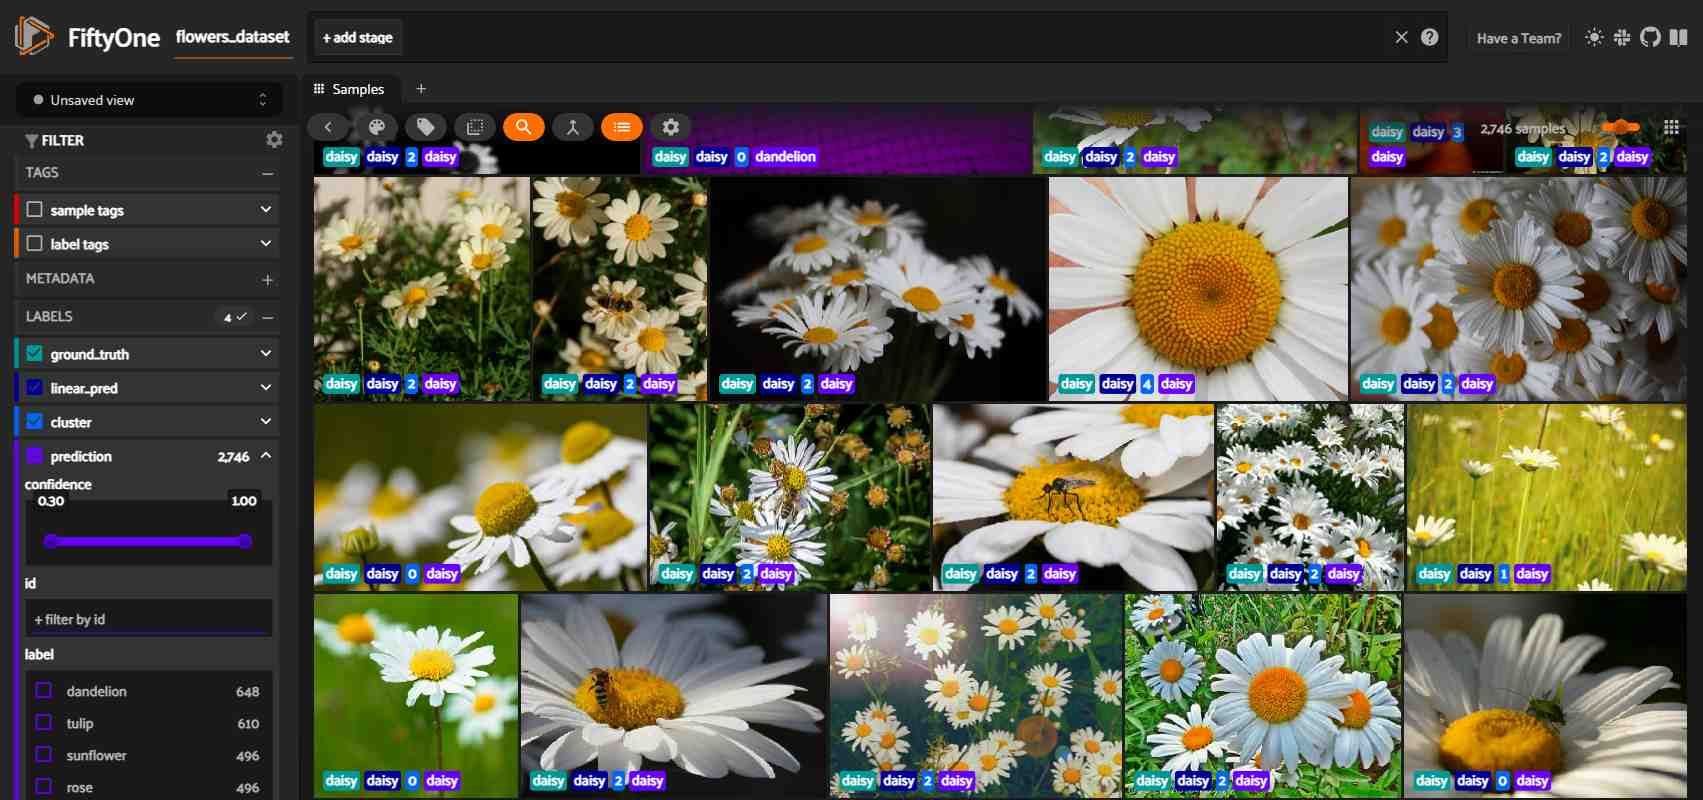

In [91]:
session = fo.launch_app(dataset)

## 4. Evaluate the Predictions

In [92]:
import fiftyone as fo
import fiftyone.brain as fob
from fiftyone import ViewField as F

In [93]:
def add_evaluation_tags_multiclass(dataset):
    for sample in dataset:
        ground_truth = sample['ground_truth'].label
        prediction = sample['prediction'].label

        # Determine if the prediction was correct
        # Since we have a multi-class situation, we tag the samples as T/F
        # We can determine TP, TN, FP, FN only in two cases:
        # - in binary classifications
        # - in multi-class classifications BUT only class-wise, using a one-vs-others scheme
        if ground_truth == prediction:
            sample.tags.append('T')  # Correct prediction
        else:
            sample.tags.append('F')  # Incorrect prediction

        # Save the changes to the sample
        sample.save()

# Call the function to add evaluation tags for multi-class
add_evaluation_tags_multiclass(dataset)

In [94]:
# Evaluate the model's predictions
# 'prediction' is the name of the field in which the model's predictions are stored
# 'ground_truth' is the name of the field containing the ground truth labels
results = dataset.evaluate_classifications(
    "prediction", # field in which the model's predictions are stored
    gt_field="ground_truth", # field containing the ground truth labels
    eval_key="eval", # eval
    #compute_mAP=True
)

In [95]:
# Aggregate metrics
results.print_report()

              precision    recall  f1-score   support

       daisy       0.98      0.97      0.97       501
   dandelion       0.98      0.98      0.98       646
        rose       0.97      0.97      0.97       497
   sunflower       0.97      0.97      0.97       495
       tulip       0.97      0.98      0.97       607

    accuracy                           0.97      2746
   macro avg       0.97      0.97      0.97      2746
weighted avg       0.97      0.97      0.97      2746



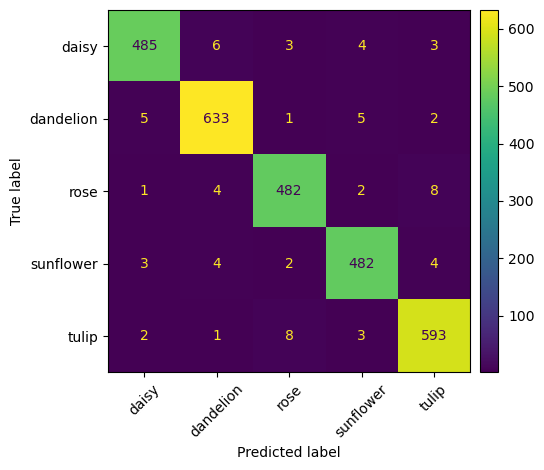

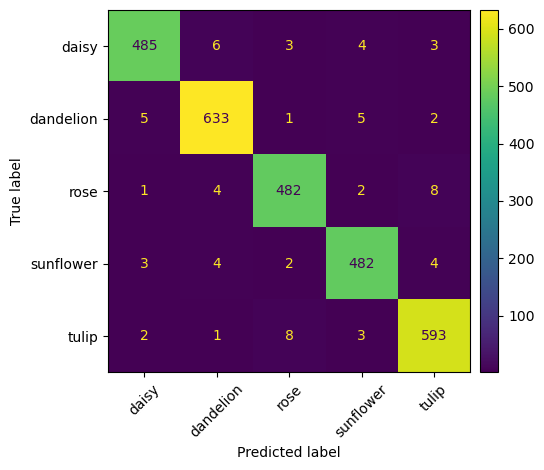

In [96]:
# Print the confusion matrix
results.plot_confusion_matrix(backend="matplotlib")

In [98]:
# Compute hardness
# Identify samples that are more difficult for a model to learn
# so that training can be more focused around these hard samples.
# You need to have the logits!
# https://docs.voxel51.com/user_guide/brain.html#sample-hardness
fob.compute_hardness(dataset, "prediction")

Computing hardness...
                                                                                      
Could not connect session, trying again in 10 seconds

 100% |███████████████| 2746/2746 [9.8s elapsed, 0s remaining, 314.3 samples/s]       
Hardness computation complete


In [99]:
# Compute mistakenness
# Automatically identify the potential ground truth mistakes in your dataset
# https://docs.voxel51.com/user_guide/brain.html#label-mistakes
fob.compute_mistakenness(dataset, "prediction", label_field="ground_truth")

Computing mistakenness...
 100% |███████████████| 2746/2746 [9.6s elapsed, 0s remaining, 290.8 samples/s]       
Mistakenness computation complete


### Views / Filters

In [100]:
# Re-Launch UI app
session = fo.launch_app(dataset)


Could not connect session, trying again in 10 seconds



```python
# To visualize the worst-performing samples (e.g., false positives)
view = dataset.filter_labels("prediction", F("label") != F("ground_truth.label"), only_matches=True)
session = fo.launch_app(view=view)
# ... OR
session = fo.launch_app(dataset)
session.view = (
    dataset
    .filter_labels("prediction", F("label") != F("ground_truth.label"), only_matches=True)
)

# Show most unique CORRECT predictions testion split
session.view = (
    dataset
    .match_tagtestion")
    .match(F("predictions.label") == F("ground_truth.label"))
    .sort_by("uniqueness", reverse=True)
)

# Show most unique INCORRECT predictions testion split
session.view = (
    dataset
    .match_tagtestion")
    .match(F("predictions.label") != F("ground_truth.label"))
    .sort_by("uniqueness", reverse=True)
)

# Show the HARDEST FASLES testion sp
# We can extend it to FP & FN if binary classificationlit
session.view = (
    dataset
    .match_tagtestion")
    .match(F("eval") =False"FP")
    .sort_by("hardness", reverse=True)
)

# Show the most likely ANNOTATION MISTAKES on the train split
session.view = (
    dataset
    .match_tags("train")
    .sort_by("mistakenness", reverse=True)
)
```

In [104]:
session.view = (
    dataset
    .filter_labels("prediction", F("label") != F("ground_truth.label"), only_matches=True)
)


Could not connect session, trying again in 10 seconds




Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

